In [24]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sb
import pandas as pd
from scipy.spatial.distance import cdist

%matplotlib inline

import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# Process data using MDAnalysis

In [2]:
u_og =  mda.Universe("first.pdb","og.pdb")
ca_og = u_og.select_atoms("name CA")

assert ca_og.universe.trajectory.frame == 0

n_frames = ca_og.universe.trajectory.n_frames
n_atoms = ca_og.n_atoms
frame_start = 0
frame_end = n_frames

ca_og_pos = np.zeros((n_frames, 3*n_atoms))
ca_og_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_og.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_og.positions.flatten()
    ca_og_pos[i,:] = tmp
    ca_og_mean_pos += ca_og.positions

ca_og_mean_pos /= (frame_end - frame_start)

In [3]:
u_mod_rt =  mda.Universe("first.pdb","fit_1_rt.pdb")
ca_rt = u_mod_rt.select_atoms("name CA")

assert ca_rt.universe.trajectory.frame == 0

n_frames = ca_rt.universe.trajectory.n_frames
n_atoms = ca_rt.n_atoms
frame_start = 0
frame_end = n_frames

ca_rt_pos = np.zeros((n_frames, 3*n_atoms))
ca_rt_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_rt.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_rt.positions.flatten()
    ca_rt_pos[i,:] = tmp
    ca_rt_mean_pos += ca_rt.positions

ca_rt_mean_pos /= (frame_end - frame_start)

In [4]:
u_mod_prog =  mda.Universe("first.pdb","fit_2_p.pdb")
ca_prog = u_mod_prog.select_atoms("name CA")

assert ca_prog.universe.trajectory.frame == 0

n_frames = ca_prog.universe.trajectory.n_frames
n_atoms = ca_prog.n_atoms
frame_start = 0
frame_end = n_frames

ca_prog_pos = np.zeros((n_frames, 3*n_atoms))
ca_prog_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_prog.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_prog.positions.flatten()
    ca_prog_pos[i,:] = tmp
    ca_prog_mean_pos += ca_prog.positions

ca_prog_mean_pos /= (frame_end - frame_start)

# 1. Perform PCA on original coordinates

In [5]:
def Cov(X):
    """
    Calculate the covariance matrix.
    Each feature is assumed to be in a column of X.
    So we subtract the mean of each column from each observation (each row value).
    X.mean(axis=0) estimates mean of each column of X.
    Then, the formula is
    Cov = A.T @ A / (N-1)
    N-1 is called Bessel's correction.
    Verify the result with numpy's covariance matrix.
    """
    
    X_scaled = X - X.mean(axis=0) 
    cov = X_scaled.transpose() @ X_scaled / (X_scaled.shape[0] - 1)

    np_cov = np.cov(X, rowvar = False)
    assert abs(cov - np_cov).all() < 1e-8
    assert np.shape(cov) == np.shape(np_cov)

    return cov


In [6]:
def my_pca(X, num_components = 2):
    """
    Do PCA.
    X: Numpy Array
    num_components: Number of components to project to. Default is set to 2.
    """

    X_scaled = X - X.mean(axis = 0)
    
    cov_matrix = Cov(X)
    eigvals , eigvecs = np.linalg.eig(cov_matrix)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    # Project data on the reduced dimensional eigenvector space
    X_projected = np.dot(eigvec_reduced_dim.transpose(), X_scaled.transpose()).transpose()
    #X_projected = np.dot(X_scaled, eigvec_reduced_dim)
    X_projected_full = X_scaled @ sorted_eigvecs

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    print(sorted_eigvals)

    return sorted_eigvals, X_projected, sorted_eigvecs

[6.60517125e+01 5.97120137e+01 5.16884810e+01 2.14160824e+01
 1.99372522e+01 1.85638928e+01 9.37619263e+00 8.64234164e+00
 7.23295481e+00 4.24701932e+00 3.47993151e+00 3.31526754e+00
 2.70329360e+00 2.26603828e+00 1.64118588e+00 5.71213921e-01
 4.47229603e-01 3.67846134e-01 3.32313656e-01 2.69652045e-01
 2.48662094e-01 2.31175149e-01 1.92222649e-01 1.67959875e-01
 8.33448485e-02 7.64858849e-02 7.17164400e-02 6.18503363e-02
 6.06623168e-02 5.05087784e-02]


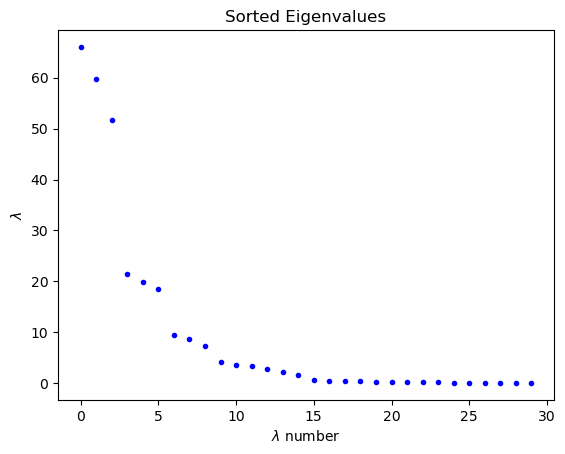

In [7]:
ca_og_eigvals, ca_og_projected, ca_og_eigvecs = my_pca(ca_og_pos,2)

In [8]:
def scree_plot(eigvals, sklearn_PCA):

    PC_values_sklearn = np.arange(sklearn_PCA.n_components_) + 1
    
    variance_contributions = np.zeros_like(eigvals)
    for i in range(len(eigvals)):
        variance_contributions[i] = eigvals[i] / np.sum(eigvals)

    sorted_variance_contributions = np.sort(variance_contributions)
    sorted_variance_contributions = sorted_variance_contributions[::-1]
    sorted_variance_indices = variance_contributions.argsort()
    sorted_variance_indices = sorted_variance_indices[::-1]

    PC_values = np.arange(sorted_variance_contributions.shape[0]) + 1
    plt.title('Scree Plot')
    plt.plot(PC_values_sklearn, sklearn_PCA.explained_variance_ratio_, 'bo-', label='sklearn PCA')
    plt.plot(PC_values, sorted_variance_contributions[:], 'r.-', label='My PCA')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend()
    plt.show()

    plt.title('Visualize variance change as we add diff PCs')
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.plot(np.cumsum(sklearn_PCA.explained_variance_ratio_), 'bo-', label='sklearn PCA')
    plt.plot(np.cumsum(sorted_variance_contributions), 'r.-', label='My PCA')
    plt.legend()
    plt.show()

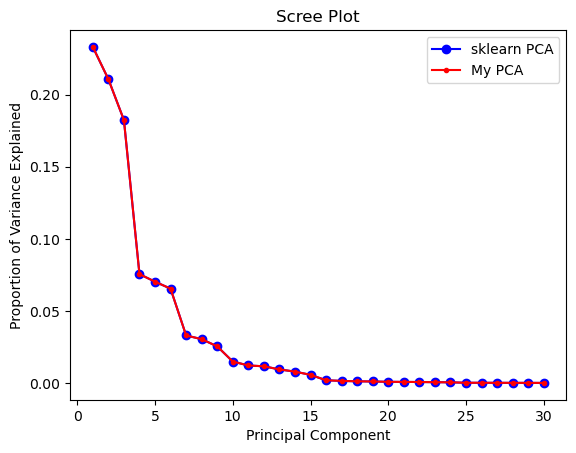

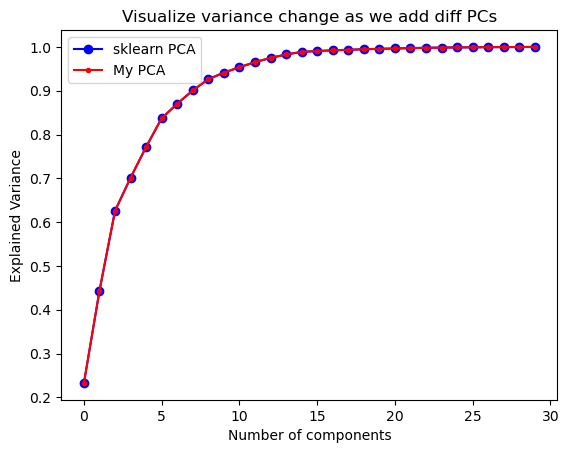

In [9]:
from sklearn.decomposition import PCA

sklearn_PCA = PCA()
sklearn_PCA.fit(ca_og_pos)
ca_og_pca = sklearn_PCA.transform(ca_og_pos)

scree_plot(ca_og_eigvals, sklearn_PCA)

# 2. Perform PCA on modified coordinates

### There are 2 different versions of alignment I did. Both were done using Gromacs.

#### a) "-fit rot+trans" corresponds to "ca_rt" labelled variables
#### b) "-fit progressive" corresponds to "ca_prog" labelled variables

[7.89146726 4.44004027 2.41637584 1.68044761 1.4758776  1.04203688
 0.95269802 0.79624361 0.59416587 0.47729224 0.38808579 0.385304
 0.26668595 0.23095332 0.19391518 0.16258998 0.16076106 0.13414487
 0.1106222  0.09073382 0.08145589 0.06691158 0.05097544 0.04639758
 0.04096395 0.03138796 0.02329492 0.01709912 0.01339281 0.00949502]


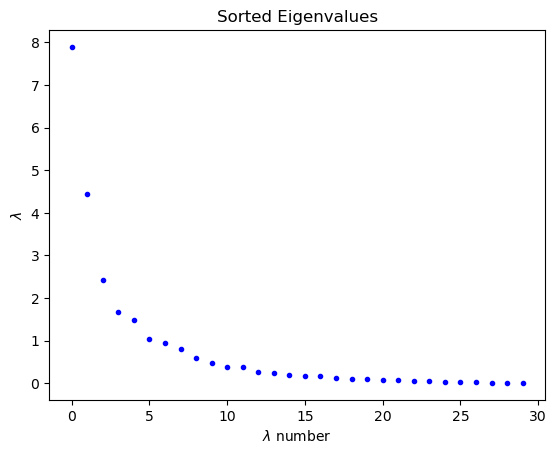

In [10]:
ca_rt_eigvals, ca_rt_projected, ca_rt_eigvecs = my_pca(ca_rt_pos,2)

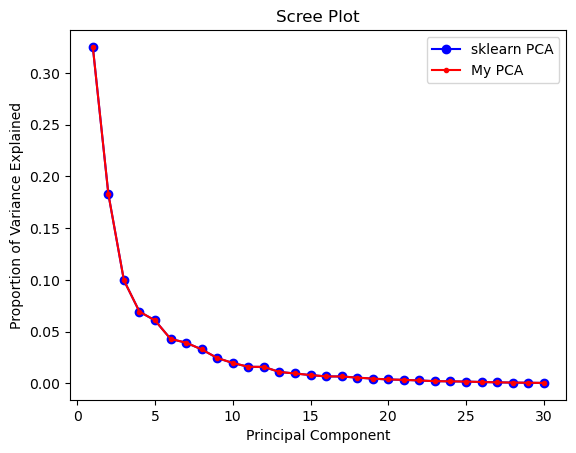

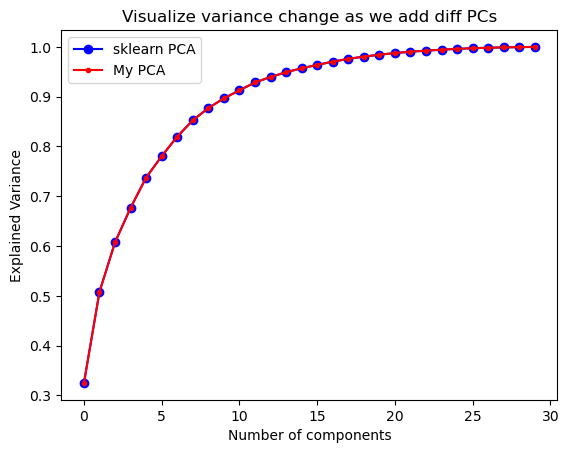

In [11]:
sklearn_PCA = PCA()
sklearn_PCA.fit(ca_rt_pos)
ca_rt_pca = sklearn_PCA.transform(ca_rt_pos)

scree_plot(ca_rt_eigvals, sklearn_PCA)

#### Plotting the configurations in the space of the first 2 PCs

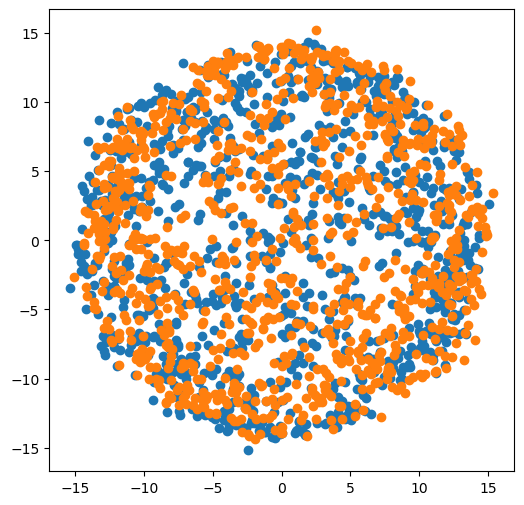

[-5.94198535 -3.92278921 -3.96344504 -4.60338987 -6.54839024 -3.93942148
 -6.93451614 -4.21183977 -2.5749126  -2.56801747]
[5.94198535 3.92278921 3.96344504 4.60338987 6.54839024 3.93942148
 6.93451614 4.21183977 2.5749126  2.56801747]


In [12]:
# plt.figure(figsize=(6,6))
# sb.scatterplot(data = ca_og_projected, s=60 , palette='icefire')
# plt.show()
plt.figure(figsize=(6,6))
plt.scatter(ca_og_projected[:,0],ca_og_projected[:,1])
plt.scatter(ca_og_pca[:,0],ca_og_pca[:,1])
plt.show()

print(ca_og_pca[:10,1])
print(ca_og_projected[:10,1])

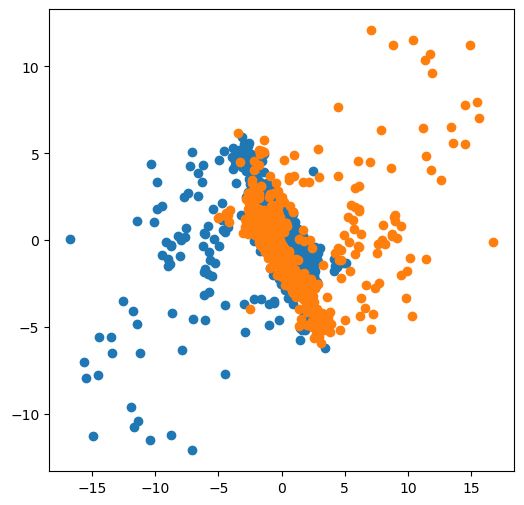

[-0.99559169  0.25154188 -0.31304062 -0.55655973 -0.30955963  0.53404207
  0.40962926 -0.3703348   0.49631925 -0.27519231]
[ 0.99559169 -0.25154188  0.31304062  0.55655973  0.30955963 -0.53404207
 -0.40962926  0.3703348  -0.49631925  0.27519231]


In [13]:
# plt.figure(figsize=(6,6))
# sb.scatterplot(data = ca_rt_projected, s=60 , palette='icefire')
# plt.show()
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_projected[:,0],ca_rt_projected[:,1])
plt.scatter(ca_rt_pca[:,0],ca_rt_pca[:,1])
plt.show()

print(ca_rt_pca[:10,1])
print(ca_rt_projected[:10,1])

In [14]:
from MDAnalysis.analysis import pca as mda_pca
from MDAnalysis.analysis import align as mda_align

test_pc = mda_pca.PCA(u_mod_rt,select="name CA",align=True,mean=None,n_components=None).run()
test_ca = u_mod_rt.select_atoms("name CA")
test_transformed = test_pc.transform(test_ca, n_components=3)

test_df = pd.DataFrame(test_transformed,
                  columns=['PC{}'.format(i+1) for i in range(3)])
test_df['Time (ps)'] = test_df.index * u_mod_rt.trajectory.dt
test_df.head()

#g = sb.PairGrid(test_df, hue='Time (ps)',
                 #palette=sb.color_palette('Oranges_d',
                 #                          n_colors=len(test_df)))
#g.map(plt.scatter, marker='.');


test_pc1 =  test_pc.p_components[:,0]
test_trans1 = test_transformed[:,0]
test_projected = np.outer(test_trans1,test_pc1) + test_pc.mean.flatten()

test_coords = test_projected.reshape(len(test_trans1), -1, 3)

test_proj1 = mda.Merge(test_ca)
test_proj1.load_new(test_coords, order="fac")

# plt.plot(test_pc.cumulated_variance[:10],'b.')
# plt.xlabel('Principal component')
# plt.ylabel('Cumulative variance')
# plt.show()

view = nv.show_mdanalysis(test_proj1.atoms)
view


NGLWidget(max_frame=999)

        PC1       PC2  Time (ps)
0 -0.272739  0.995592        0.0
1  0.815994 -0.251542        1.0
2  0.379212  0.313041        2.0
3  0.307999  0.556560        3.0
4  1.082974  0.309560        4.0


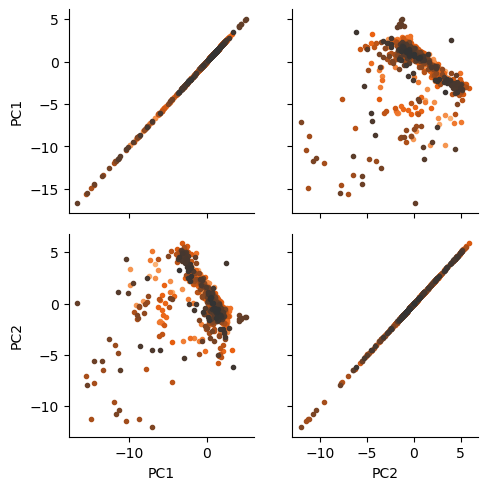

In [15]:
ca_rt_df = pd.DataFrame(ca_rt_projected,
                  columns=['PC{}'.format(i+1) for i in range(2)])
ca_rt_df['Time (ps)'] = ca_rt_df.index * u_mod_rt.trajectory.dt
print(ca_rt_df.head())

ca_rt_sb_plot = sb.PairGrid(ca_rt_df, hue='Time (ps)',
                 palette=sb.color_palette('Oranges_d',
                                           n_colors=len(ca_rt_df)))
ca_rt_sb_plot.map(plt.scatter, marker='.');

In [21]:
rt_proj = np.outer(ca_rt_projected[:,0], ca_rt_eigvecs[:,0]) + ca_rt_mean_pos.flatten()

rt_pc1_coords = rt_proj.reshape(len(test_trans1), -1, 3)

rt_proj_pc1 = mda.Merge(ca_rt)
rt_proj_pc1.load_new(rt_pc1_coords, order="fac")

view_rt = nv.show_mdanalysis(rt_proj_pc1.atoms)
view_rt

NGLWidget(max_frame=999)

# 3. MDS with dRMSD metric

In [125]:
# Testing drmsd

T=5   # Number of time-steps
N=10  # Number of atoms
dim=3 # Number of spatial dimensions of the atoms

np.random.seed(1729)

## Creating the data

#X = [[np.random.randn(dim) for a in range(N)]for t in range(T)]
X = np.random.randint(1,10,size=(T*N*dim))

X =  np.array(X)
X = X.reshape(T,N,dim)
print(X.shape)

# Creating the distance matrix
d = [cdist(X[t],X[t], metric = 'euclidean')for t in range(T)]
d = np.array(d)
print(d.shape)

drmsd = [np.sqrt(((d[tA][np.triu_indices(N,1)]-d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
drmsd = np.array(drmsd)
drmsd = drmsd.reshape(T,T)
print(drmsd.shape)

X = X.reshape(T,-1)
print(X.shape)
print(drmsd)
print(X)

(5, 3, 3)
(5, 3, 3)
(5, 5)
(5, 9)
[[0.         2.8080795  3.06722481 4.06501652 1.7801517 ]
 [2.8080795  0.         0.7107423  2.80047018 1.94444555]
 [3.06722481 0.7107423  0.         2.22051008 2.16676774]
 [4.06501652 2.80047018 2.22051008 0.         2.87509813]
 [1.7801517  1.94444555 2.16676774 2.87509813 0.        ]]
[[7 4 6 6 4 4 2 5 4]
 [7 4 4 1 1 6 2 4 2]
 [6 3 5 1 8 5 7 8 3]
 [9 3 1 8 8 5 1 3 2]
 [4 2 8 4 4 4 8 6 3]]


In [134]:
def drmsd(X):
    T = X.shape[0]
    X = X.reshape(T,-1,3)
    
    print(X.shape)

    _,N,_ = X.shape

    d = [cdist(X[t],X[t], metric = 'euclidean')for t in range(T)]
    d = np.array(d)
    print(d.shape)

    drmsd_mat = [np.sqrt(((d[tA][np.triu_indices(N,1)]-d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
    drmsd_mat = np.array(drmsd_mat)
    drmsd_mat = drmsd_mat.reshape(T,T)
    print(drmsd_mat.shape)

    return drmsd_mat

#drmsd(ca_rt_pos)
    

In [135]:
def my_mds(X, num_components = 2):
    """
    Do MDS. Here the distance metric is the "dRMSD".
    X: Numpy Array
    num_components: Number of components to project to. Default is set to 2.
    """

    N = X.shape[0] # number of data points
    dist_matrix = np.zeros((N,N)) # delta_{i,j} from notes

    dist_matrix = drmsd(X)

    I = np.identity(N)
    Jn = np.ones((N,N))
    Jn = Jn/N
    C = I - Jn

    # Double Centering
    B = -(C @ dist_matrix @ C)/2
    
    eigvals , eigvecs = np.linalg.eig(B)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    print(sorted_eigvals)

    return sorted_eigvals

(1000, 10, 3)
(1000, 10, 10)
(1000, 1000)
[2.04922980e+02 1.00911693e+02 6.78174472e+01 5.80502519e+01
 3.34077694e+01 2.82050226e+01 2.47102593e+01 1.92907943e+01
 1.76674232e+01 1.47072378e+01 1.38497001e+01 1.27563364e+01
 1.13133896e+01 1.06618452e+01 8.05126530e+00 7.87493095e+00
 7.27786432e+00 7.05602740e+00 6.57767980e+00 6.15892964e+00
 6.01452262e+00 5.20921532e+00 5.19014938e+00 4.91724370e+00
 4.72274198e+00 4.59636944e+00 4.41646830e+00 3.83544316e+00
 3.69594567e+00 3.63915165e+00 3.45642954e+00 3.30843974e+00
 3.14141625e+00 3.06603593e+00 2.93670246e+00 2.89987693e+00
 2.81056964e+00 2.67753071e+00 2.63887079e+00 2.52388304e+00
 2.46267591e+00 2.39169528e+00 2.28082523e+00 2.20300628e+00
 2.07192404e+00 2.03424996e+00 1.98494778e+00 1.93066079e+00
 1.90821810e+00 1.80613736e+00 1.74631125e+00 1.72603793e+00
 1.67873076e+00 1.65982063e+00 1.61480794e+00 1.53405024e+00
 1.50908287e+00 1.47627929e+00 1.44889861e+00 1.42864959e+00
 1.39778357e+00 1.39058965e+00 1.36012883e+

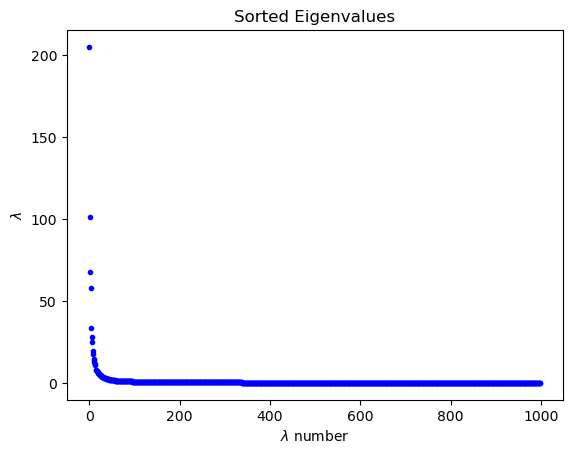

In [137]:
ca_rt_mds_eigvals = my_mds(ca_rt_pos)

In [138]:
def scree_plot_mds(eigvals):
    
    variance_contributions = np.zeros_like(eigvals)
    for i in range(len(eigvals)):
        variance_contributions[i] = eigvals[i] / np.sum(eigvals)

    sorted_variance_contributions = np.sort(variance_contributions)
    sorted_variance_contributions = sorted_variance_contributions[::-1]
    sorted_variance_indices = variance_contributions.argsort()
    sorted_variance_indices = sorted_variance_indices[::-1]

    PC_values = np.arange(sorted_variance_contributions.shape[0]) + 1
    plt.title('Scree Plot')
    plt.plot(PC_values, sorted_variance_contributions[:], 'r.-', label='My MDS')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend()
    plt.show()

    plt.title('Visualize variance change as we add diff PCs')
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.plot(np.cumsum(sorted_variance_contributions), 'r.-', label='My MDS')
    plt.legend()
    plt.show()

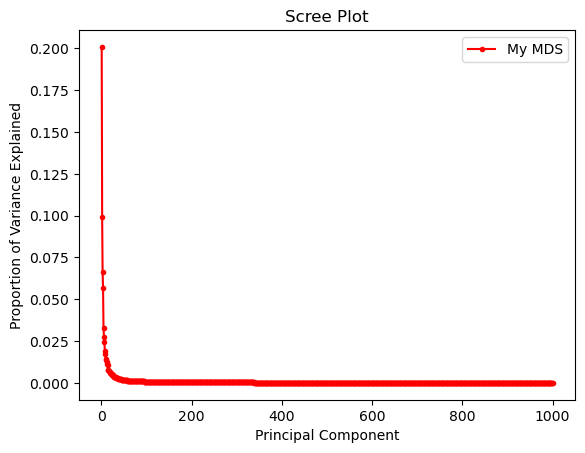

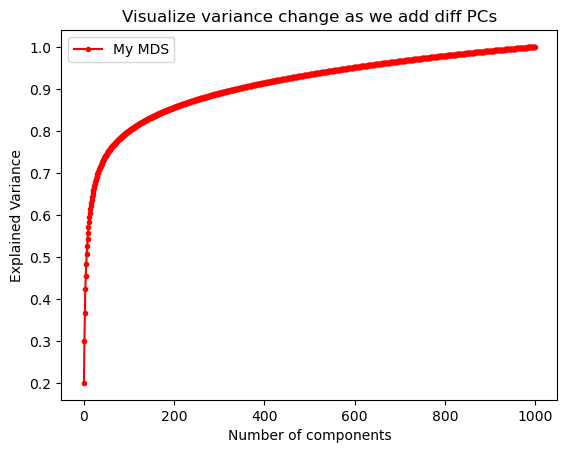

In [139]:
scree_plot_mds(ca_rt_mds_eigvals)

(-21.633777369103434,
 21.508458257082854,
 -14.965302194467858,
 14.682477065906825)

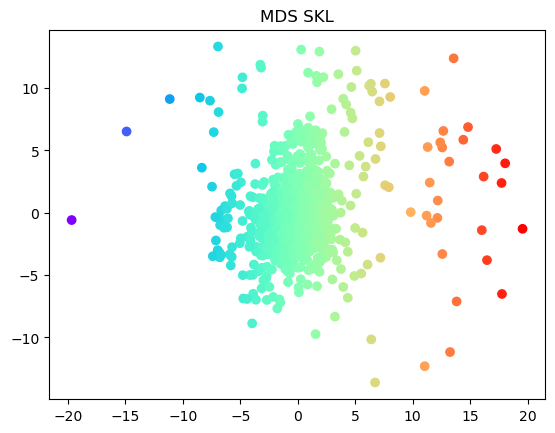

In [19]:
from sklearn.manifold import MDS

sklearn_MDS = MDS()
sklearn_MDS.fit(ca_rt_pos)
ca_rt_mds_skl = sklearn_MDS.fit_transform(ca_rt_pos)

plt.scatter(ca_rt_mds_skl[:,0], ca_rt_mds_skl[:,1], c=ca_rt_mds_skl[:,0], cmap=plt.cm.rainbow)
plt.title("MDS SKL")
plt.axis("tight")

(-21.633777369103434,
 21.508458257082854,
 -14.965302194467858,
 14.682477065906825)

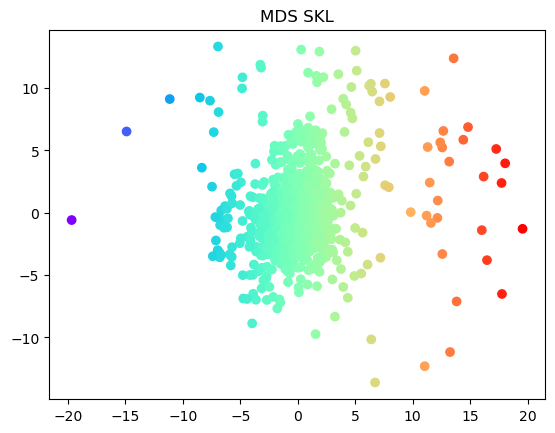

In [20]:
plt.scatter(sklearn_MDS.embedding_[:,0], sklearn_MDS.embedding_[:,1], c=sklearn_MDS.embedding_[:,0], cmap=plt.cm.rainbow)
plt.title("MDS SKL")
plt.axis("tight")